In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import anndata as ad
from collections import defaultdict, Counter
import math
import sklearn.decomposition
import sklearn.preprocessing
from plotnine import ggplot, aes, theme, labs, element_text, theme_classic, geom_point, coord_fixed
import pybedtools as pb
import sklearn.mixture


from IPython.display import display
from importlib import reload

from dnam_preprocessing import get_targeted_dnam, show_ad, get_ages, compute_obs_attributes
import filenames

In [3]:
ad10_all, ad100_all, ad10, ad100, df_testset, ages_testset = get_targeted_dnam()
ages_cpg_sorted = get_ages(ad100)
ad100_notadpoles = ad100.copy()
ad100_notadpoles = ad100_notadpoles[:, ~ad100_notadpoles.var['Is tadpole?']]
compute_obs_attributes(ad100_notadpoles)

# Examples of observing subsets of the data:
# ad100[:, ad100.var['Tank'] != 'A337'].shape
# ad100[ad100.obs['spearman'] > 0]
# ad100[:, ~ad100.var['Is tadpole?']].shape
# ad100[abs(ad100.obs['spearman']) > 0.4].to_df().index

print(ad100)
show_ad(ad100)

/Users/ronan/_xenopus-aging/xenopus-aging/A DNA methylation clock for Xenopus frogs/dnam_preprocessing.py:68: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


View of AnnData object with n_obs × n_vars = 6183 × 192
    obs: 'Site', 'CHR', 'BP', 'spearman', 'spearman_p', 'pearson', 'pearson_p', 'is_genetic'
    var: 'Unique Frog ID', 'DOB', 'Sampled Date', 'Age (days)', 'Age (months)', 'Age (years)', 'Is tadpole?', 'Tank', 'Strain', 'Has TBSeq data?', 'Lane', 'i7 Index', 'i7(?) Index Sequence', 'i5 Index', 'i5(?) Index Sequence', ' Total Number of Reads per Sample  ', 'Expected Number of Reads Per Sample', 'Run ', 'Run Type', 'Library Prep'


,1-Tadpole,2-Tadpole,4-Tadpole,14-Tadpole,15-Tadpole,165,166,167,168,169,...,55,56,57,58,59,60,spearman,spearman_p,pearson,pearson_p
Site,,,,,,,,,,,,,,,,,,,,,
Chr3:36676488,0.850811,0.832653,0.865186,0.671875,0.630435,0.462415,0.568493,0.631272,0.665066,0.562555,...,0.393812,0.449210,0.403297,0.393574,0.369246,0.427812,-0.781450,8.881552e-41,-0.731940,1.730722e-33
Chr6:88833379,0.938825,0.954813,0.949430,0.901774,0.923618,0.905103,0.886076,0.876698,0.905274,0.884397,...,0.819978,0.811918,0.811525,0.843700,0.824652,0.803440,-0.775371,8.764715e-40,-0.685669,5.230109e-28
Chr1:33277155,0.901961,0.905660,0.907588,0.874060,0.868347,0.809961,0.830443,0.860051,0.828927,0.828671,...,0.538226,0.467033,0.446790,0.453074,0.515050,0.523543,-0.761119,1.432265e-37,-0.715501,2.041906e-31
Chr3:53115546,0.813627,0.835329,0.814458,0.575758,0.597938,0.577381,0.593525,0.608414,0.674699,0.661017,...,0.326633,0.484581,0.398496,0.446154,0.413655,0.395928,-0.750174,5.667807e-36,-0.703630,5.215887e-30
Chr1:32298887,0.808411,0.794286,0.819599,0.672365,0.696429,0.682119,0.658933,0.669516,0.671875,0.631793,...,0.516129,0.513846,0.470085,0.492063,0.558904,0.568571,-0.744839,3.178313e-35,-0.699781,1.440906e-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Chr8:36144539,0.827423,0.749235,0.780549,0.832487,0.833333,0.835821,0.852941,0.856589,0.851282,0.876081,...,0.911917,0.856410,0.876404,0.810345,0.841040,0.923596,0.000346,9.962011e-01,0.046742,5.197024e-01
Chr7:66888395,0.918317,0.917910,0.957655,0.937198,0.936508,0.927757,0.913420,0.924460,0.924901,0.945344,...,0.945876,0.951542,0.918987,0.916300,0.946092,0.953659,0.000203,9.977692e-01,0.039903,5.826515e-01
Chr6:100540884,0.923077,0.917808,0.956633,0.933014,0.948276,0.956656,0.959677,0.948127,0.950000,0.972540,...,0.960212,0.985507,0.969780,0.977778,0.967337,0.951282,-0.000203,9.977739e-01,0.033287,6.467004e-01


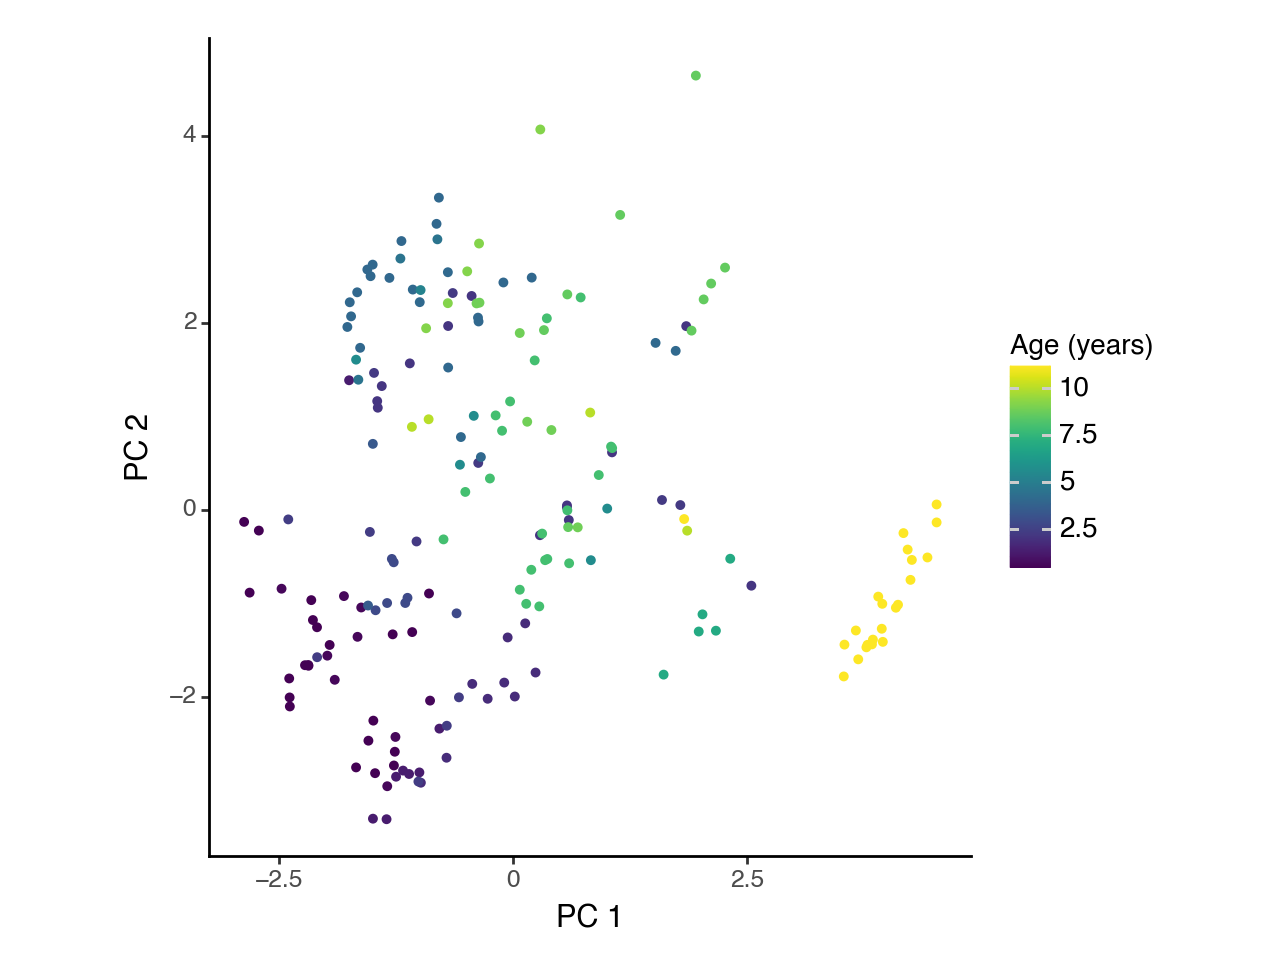


pc_corrs [0.7385620171070784, 0.39674482280304507, -0.018448433703888822, -0.331785691730493, 0.12470747430793126, 0.18358643292005336, -0.2952733775211508, 0.15004198621825343, 0.0881868802450342, -0.06361319487802805]


In [5]:
# Supplementary Figure 3A
# PCA

def pca(frogs_by_measurements_df, ages_cpg_sorted, n_components, center_data=True, center_and_scale=False):
    # PCA :  (n_frogs x n_cpgs) -> (n_frogs x n_components)
    pc_obj = sklearn.decomposition.PCA(n_components = n_components)
    if center_data:
        mean_values = frogs_by_measurements_df.mean(axis=0)
        frogs_by_measurements_df = frogs_by_measurements_df - mean_values
    elif center_and_scale: # each column of cpg over all frogs is normalized to mean 0 variance 1
        s = sklearn.preprocessing.StandardScaler()
        s.fit(frogs_by_measurements_df)
        frogs_by_measurements_df = s.transform(frogs_by_measurements_df)  # scales s.t mean(axis=0) = 0 and std(axis=0) = 1
    pcs = pc_obj.fit_transform(frogs_by_measurements_df)

    df = pd.DataFrame({
    'PC1': pcs[:, 0],
    'PC2': pcs[:, 1],
    'Age': ages_cpg_sorted
    })
    p = (ggplot(df, aes(x='PC1', y='PC2', color='Age'))
        + geom_point(size=1)
        # + scale_color_cmap(cmap_name='viridis')
        + labs(color='Age (years)', x='PC 1', y='PC 2')
        + theme_classic()
        + coord_fixed()
        + theme(
         legend_title=element_text(size=10),
         legend_text=element_text(size=10),
         legend_key_size=10,
       )
        )
    print(p)

    pc_corrs = [scipy.stats.spearmanr(ages_cpg_sorted, pcs[:,i])[0] for i in range(pcs.shape[1])]
    print("pc_corrs", pc_corrs)

# pca(ad100_notadpoles.X.T, ad100_notadpoles.var['Age (years)'], n_components=10, center_data=False, center_and_scale=False)
pca(ad100_notadpoles.X.T, ad100_notadpoles.var['Age (years)'], n_components=10, center_data=True, center_and_scale=False)
# pca(ad100_notadpoles.X.T, ad100_notadpoles.var['Age (years)'], n_components=10, center_data=False, center_and_scale=True)

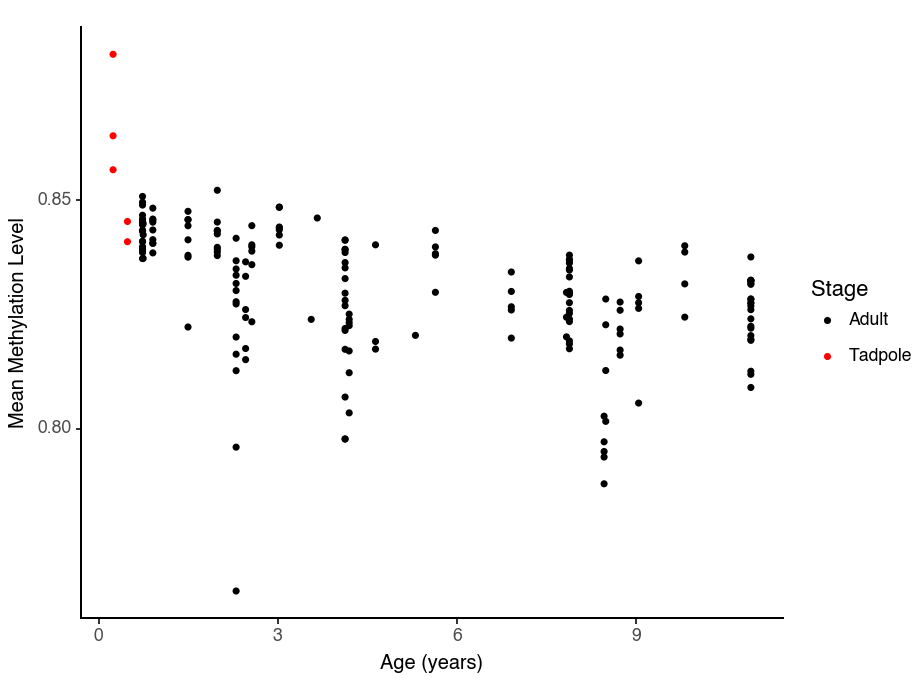


age corr:  PearsonRResult(statistic=-0.4662862597677614, pvalue=9.345948736550337e-12)
min  0.76454264 max  0.88185686


In [4]:
# Supplementary figure 3B
from plotnine import ggplot, aes, geom_violin, geom_jitter, theme, theme_minimal, labs, geom_boxplot, geom_bar, element_text, position_dodge, geom_text, theme_classic, geom_hline, geom_point, scale_color_cmap, guides, guide_colourbar, coord_fixed, facet_wrap, scale_color_manual
# Mean methylation plot
mean_methylation = ad100.X.mean(axis=0)  # mean methylation level per frog
df_methylation = pd.DataFrame({
    'Age': ages_cpg_sorted,
    'Mean_Methylation': mean_methylation,
    "Is Tadpole" : ad100.var['Is tadpole?']
})
methylation_plot = (
    ggplot(df_methylation, aes(x='Age', y='Mean_Methylation', color='Is Tadpole'))
    + geom_point(size=1)
    + scale_color_manual(values={True: "red", False: "black"}, labels=["Adult", "Tadpole"])
    + labs(x="Age (years)", y="Mean Methylation Level", color="Stage")
    + theme_classic()
    + theme(
        plot_title=element_text(size=12),
        axis_title=element_text(size=10)
    )
)
print(methylation_plot)
print('age corr: ', scipy.stats.pearsonr(ages_cpg_sorted,mean_methylation))
print('min ', min(mean_methylation), 'max ', max(mean_methylation))

0.060301780286582715 6666 110544
0.05627623389781444 6221 110544
0.014812663374963694 51 3443
0.014812663374963694 51 3443
0.03443877551020408 3807 110544
0.031715877840497904 3506 110544
0.00551844321812373 19 3443
0.00551844321812373 19 3443
# sites shared =  3506


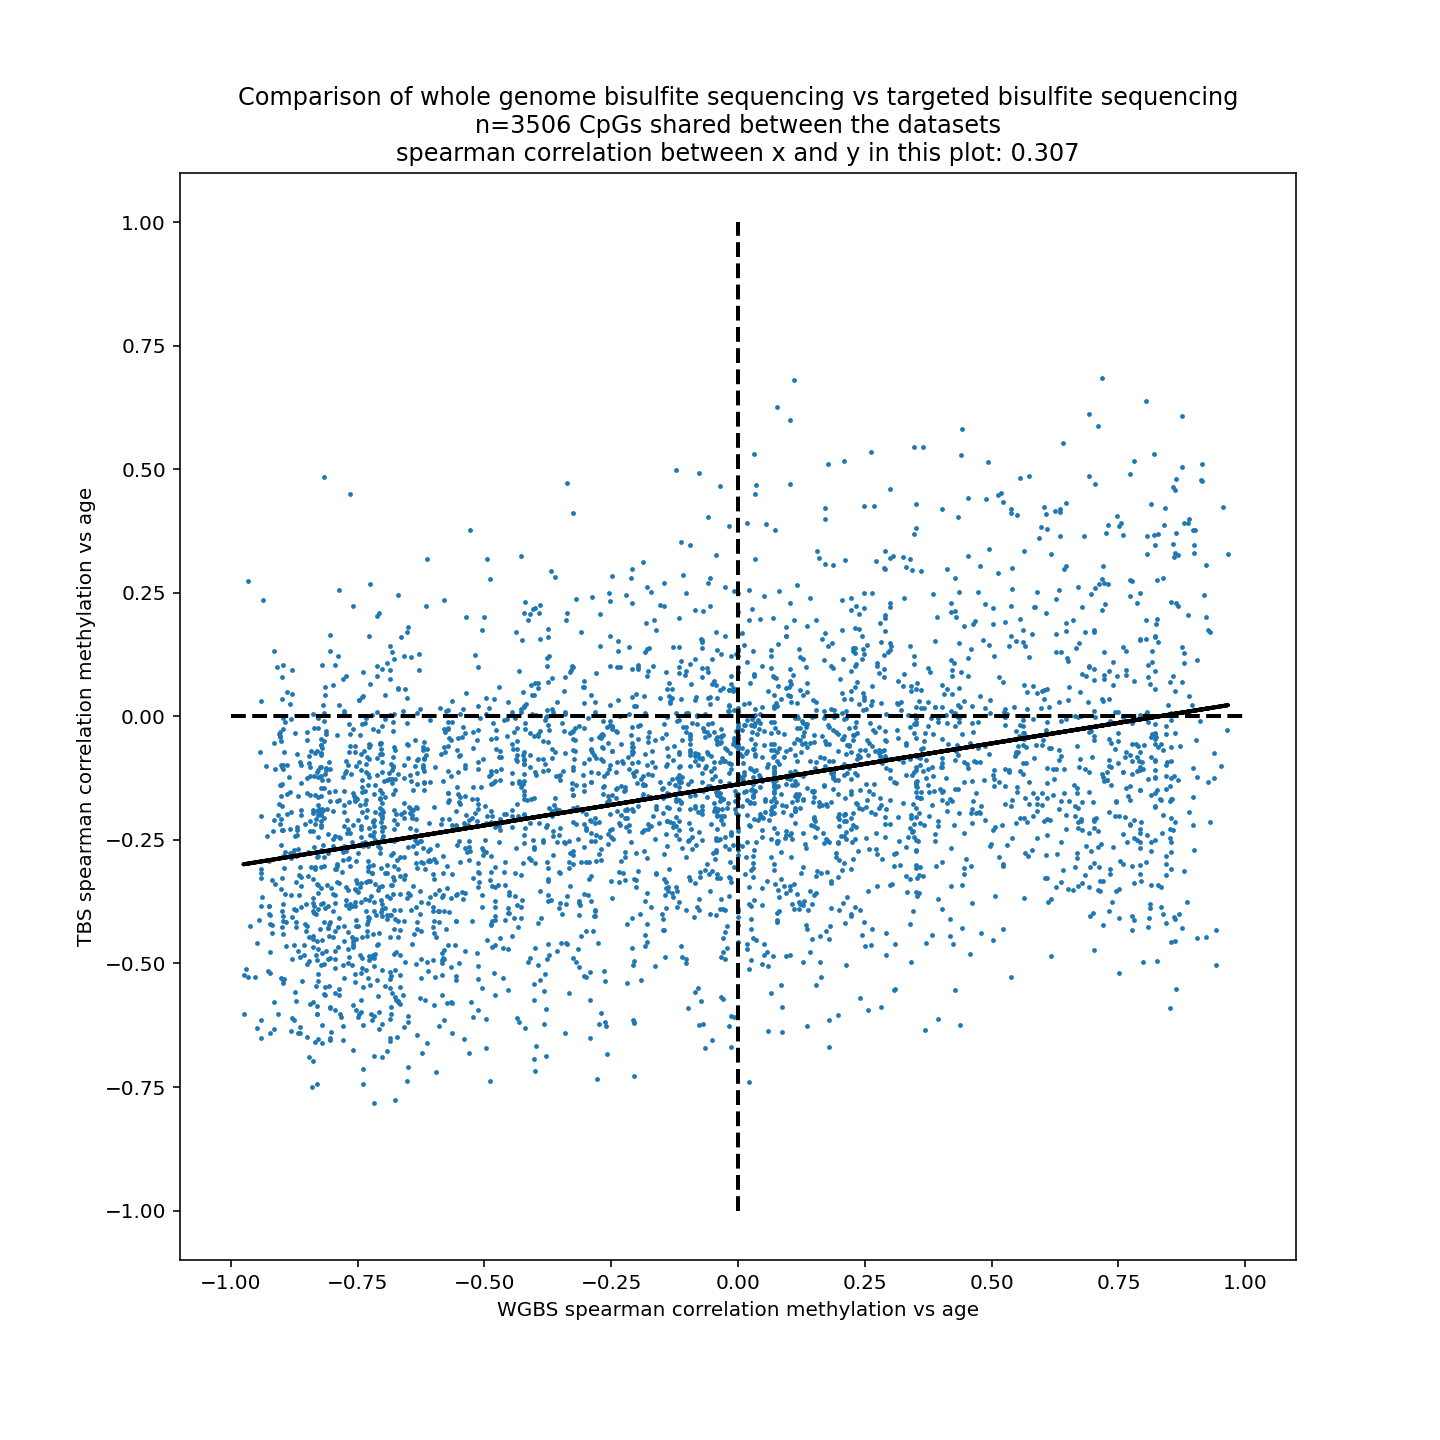

In [7]:
# Supplementary Figure 1
# Comparison to WGBS data

def preprocess_pilot_matrix(matrix_fname, parse_sample_fn, name_to_age, variance_threshold=None, truncate_after=None, sep='\t'):
    meth_matrix = pd.read_csv(matrix_fname, sep=sep)  # file taken from /u/m/mmorsell/XenTro/CGmatrix_3x/CGmatrix_5x_100.txt
    if truncate_after:
        meth_matrix = meth_matrix.truncate(after=truncate_after)
    datacols = [parse_sample_fn(col) for col in meth_matrix.columns[1:]]
    # rename every column
    sites_col = meth_matrix['Site']
    meth_matrix.columns = [meth_matrix.columns[0]] + datacols
    datacols.sort(key=lambda x: name_to_age[x])  # sort cols by increasing age
    meth_matrix = meth_matrix[datacols]
    if variance_threshold:
        meth_matrix = meth_matrix.loc[meth_matrix.var(axis=1) >= variance_threshold]
        sites_col = sites_col[meth_matrix.index]
    return meth_matrix, sites_col

def pilot_parse_sample(col_str):
    for i in range(len(col_str)):
        if col_str[i].isdigit():
            age_index = int(col_str[i:])
            return age_index

pilot_name_to_age = {1:3364./365, 2:3364./365, 3:3364./365,
                       4:1923./365, 5:1900./365, 6:1900./365,
                       7:307./365, 8:307./365, 9:277./365,}
pilot_matrix, pilot_sites = preprocess_pilot_matrix(filenames.PILOT_CGMATRIX_TSV, 
                                                pilot_parse_sample, pilot_name_to_age, None, 110543, '\t')


pilot_matrix.index = pilot_sites.str.replace('_', ':')
t_sites_10 = set(list(ad10_all.obs['Site']))
t_sites_filtered_10 = set(list(ad10.obs['Site']))
t_sites_100 = set(list(ad100_all.obs['Site']))
t_sites_filtered_100 = set(list(ad100.obs['Site']))
p_sites = set(list(pilot_matrix.index))


probes_bed = pb.BedTool(filenames.TARGETED_PROBES_BED)
probes = []
for line in probes_bed:
    probes.append(f"{line.fields[0]}:{line.fields[1]}")
probes = set(probes)

def site_overlap(t_sites, p_sites):
    print(len(t_sites.intersection(p_sites))  / len(p_sites), len(t_sites.intersection(p_sites))  , len(p_sites))

site_overlap(t_sites_10, p_sites)
site_overlap(t_sites_filtered_10, p_sites)
site_overlap(t_sites_10, probes)
site_overlap(t_sites_filtered_10, probes)

site_overlap(t_sites_100, p_sites)
site_overlap(t_sites_filtered_100, p_sites)
site_overlap(t_sites_100, probes)
site_overlap(t_sites_filtered_100, probes)

def comparison(pilot_sites, tbs_ad_obj, title=""):
    t_sites = set(list(tbs_ad_obj.obs['Site']))
    shared = list(t_sites.intersection(pilot_sites))
    print("# sites shared = ", len(shared))
    pilot_ages = [pilot_name_to_age[col] for col in pilot_matrix.columns]
    pilot_corrs = []
    for _, cpgrow in pilot_matrix.loc[shared].iterrows():
        if not (cpgrow.values == [1.,1.,1.,1.,1.,1.,1.,1.,1.]).all():
            corr = scipy.stats.spearmanr(pilot_ages, cpgrow.values)[0] 
        else:
            corr = 0.
        if np.isnan(corr):
            raise RuntimeError("this shouldn't happen")
        pilot_corrs.append(corr)
    tbs_corrs = tbs_ad_obj[shared].obs['spearman']


    plt.figure(figsize=(10,10))
    plt.scatter(pilot_corrs, tbs_corrs, s = 2)
    # best fit line
    m, b = np.polyfit(pilot_corrs, tbs_corrs, 1)  # Linear fit (degree 1)
    plt.plot(pilot_corrs, m * np.array(pilot_corrs) + b, color='black', linewidth=2)

    plt.vlines(0,-1,1,linestyle='--', color='black', linewidth=2)
    plt.plot([-1, 1], [0,0], linestyle='--', color='black', linewidth=2)
    plt.xlabel("WGBS spearman correlation methylation vs age")
    plt.ylabel("TBS spearman correlation methylation vs age")
    plt.title(title)
    plt.show()

# comparison(p_sites, ad10, "10x filtered")
comparison(p_sites, ad100, "Comparison of whole genome bisulfite sequencing vs targeted bisulfite sequencing\nn=3506 CpGs shared between the datasets\nspearman correlation between x and y in this plot: 0.307")

In [ ]:
# Supplementary table 3
df_geno = pd.read_csv("./genotype_matrix.txt", sep='\t')  # output from bsbolt GenotypeMatrix
newcolnames = [df_geno.columns[0]]
for col in df_geno.columns[1:]:
    newcolnames.append(col.split('.')[0])
df_geno.columns = newcolnames
df_geno = df_geno.set_index('Site')
df_geno.to_csv('./df_geno.tsv', sep='\t')  # Supplementary table 3

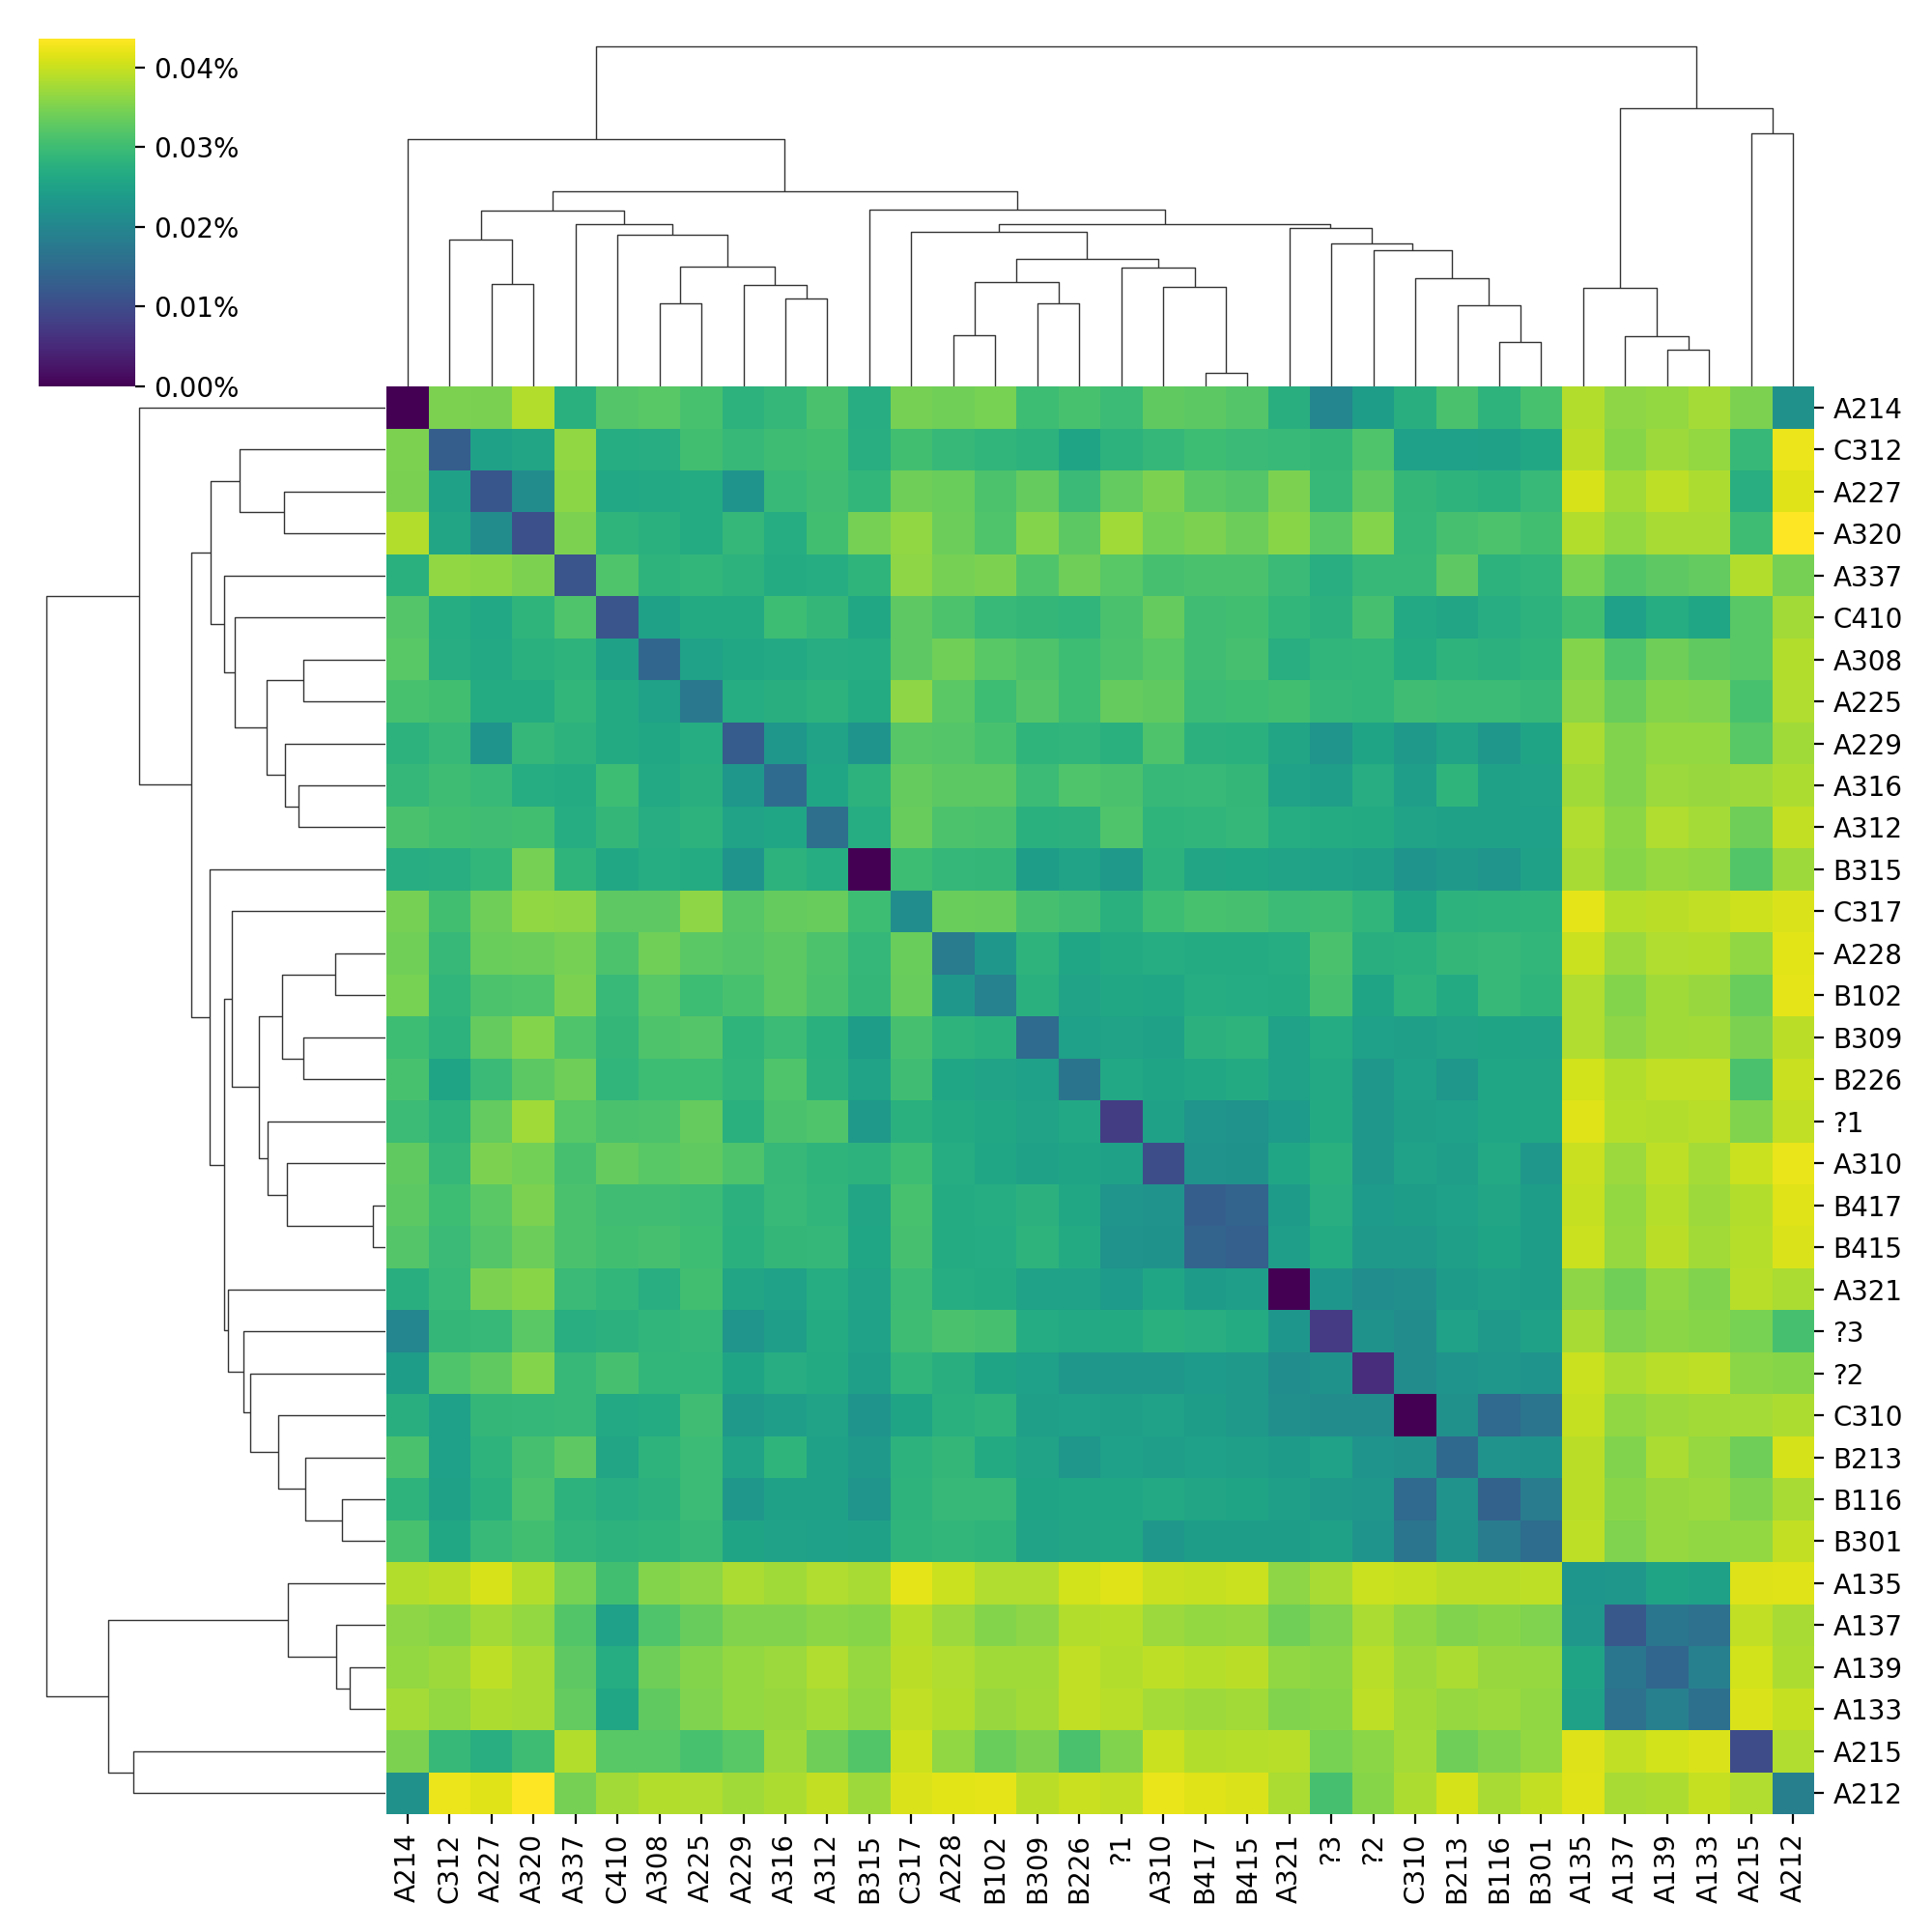

/Users/ronan/.local/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/Users/ronan/.local/lib/python3.10/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
/Users/ronan/.local/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
/Users/ronan/.local/lib/python3.10/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


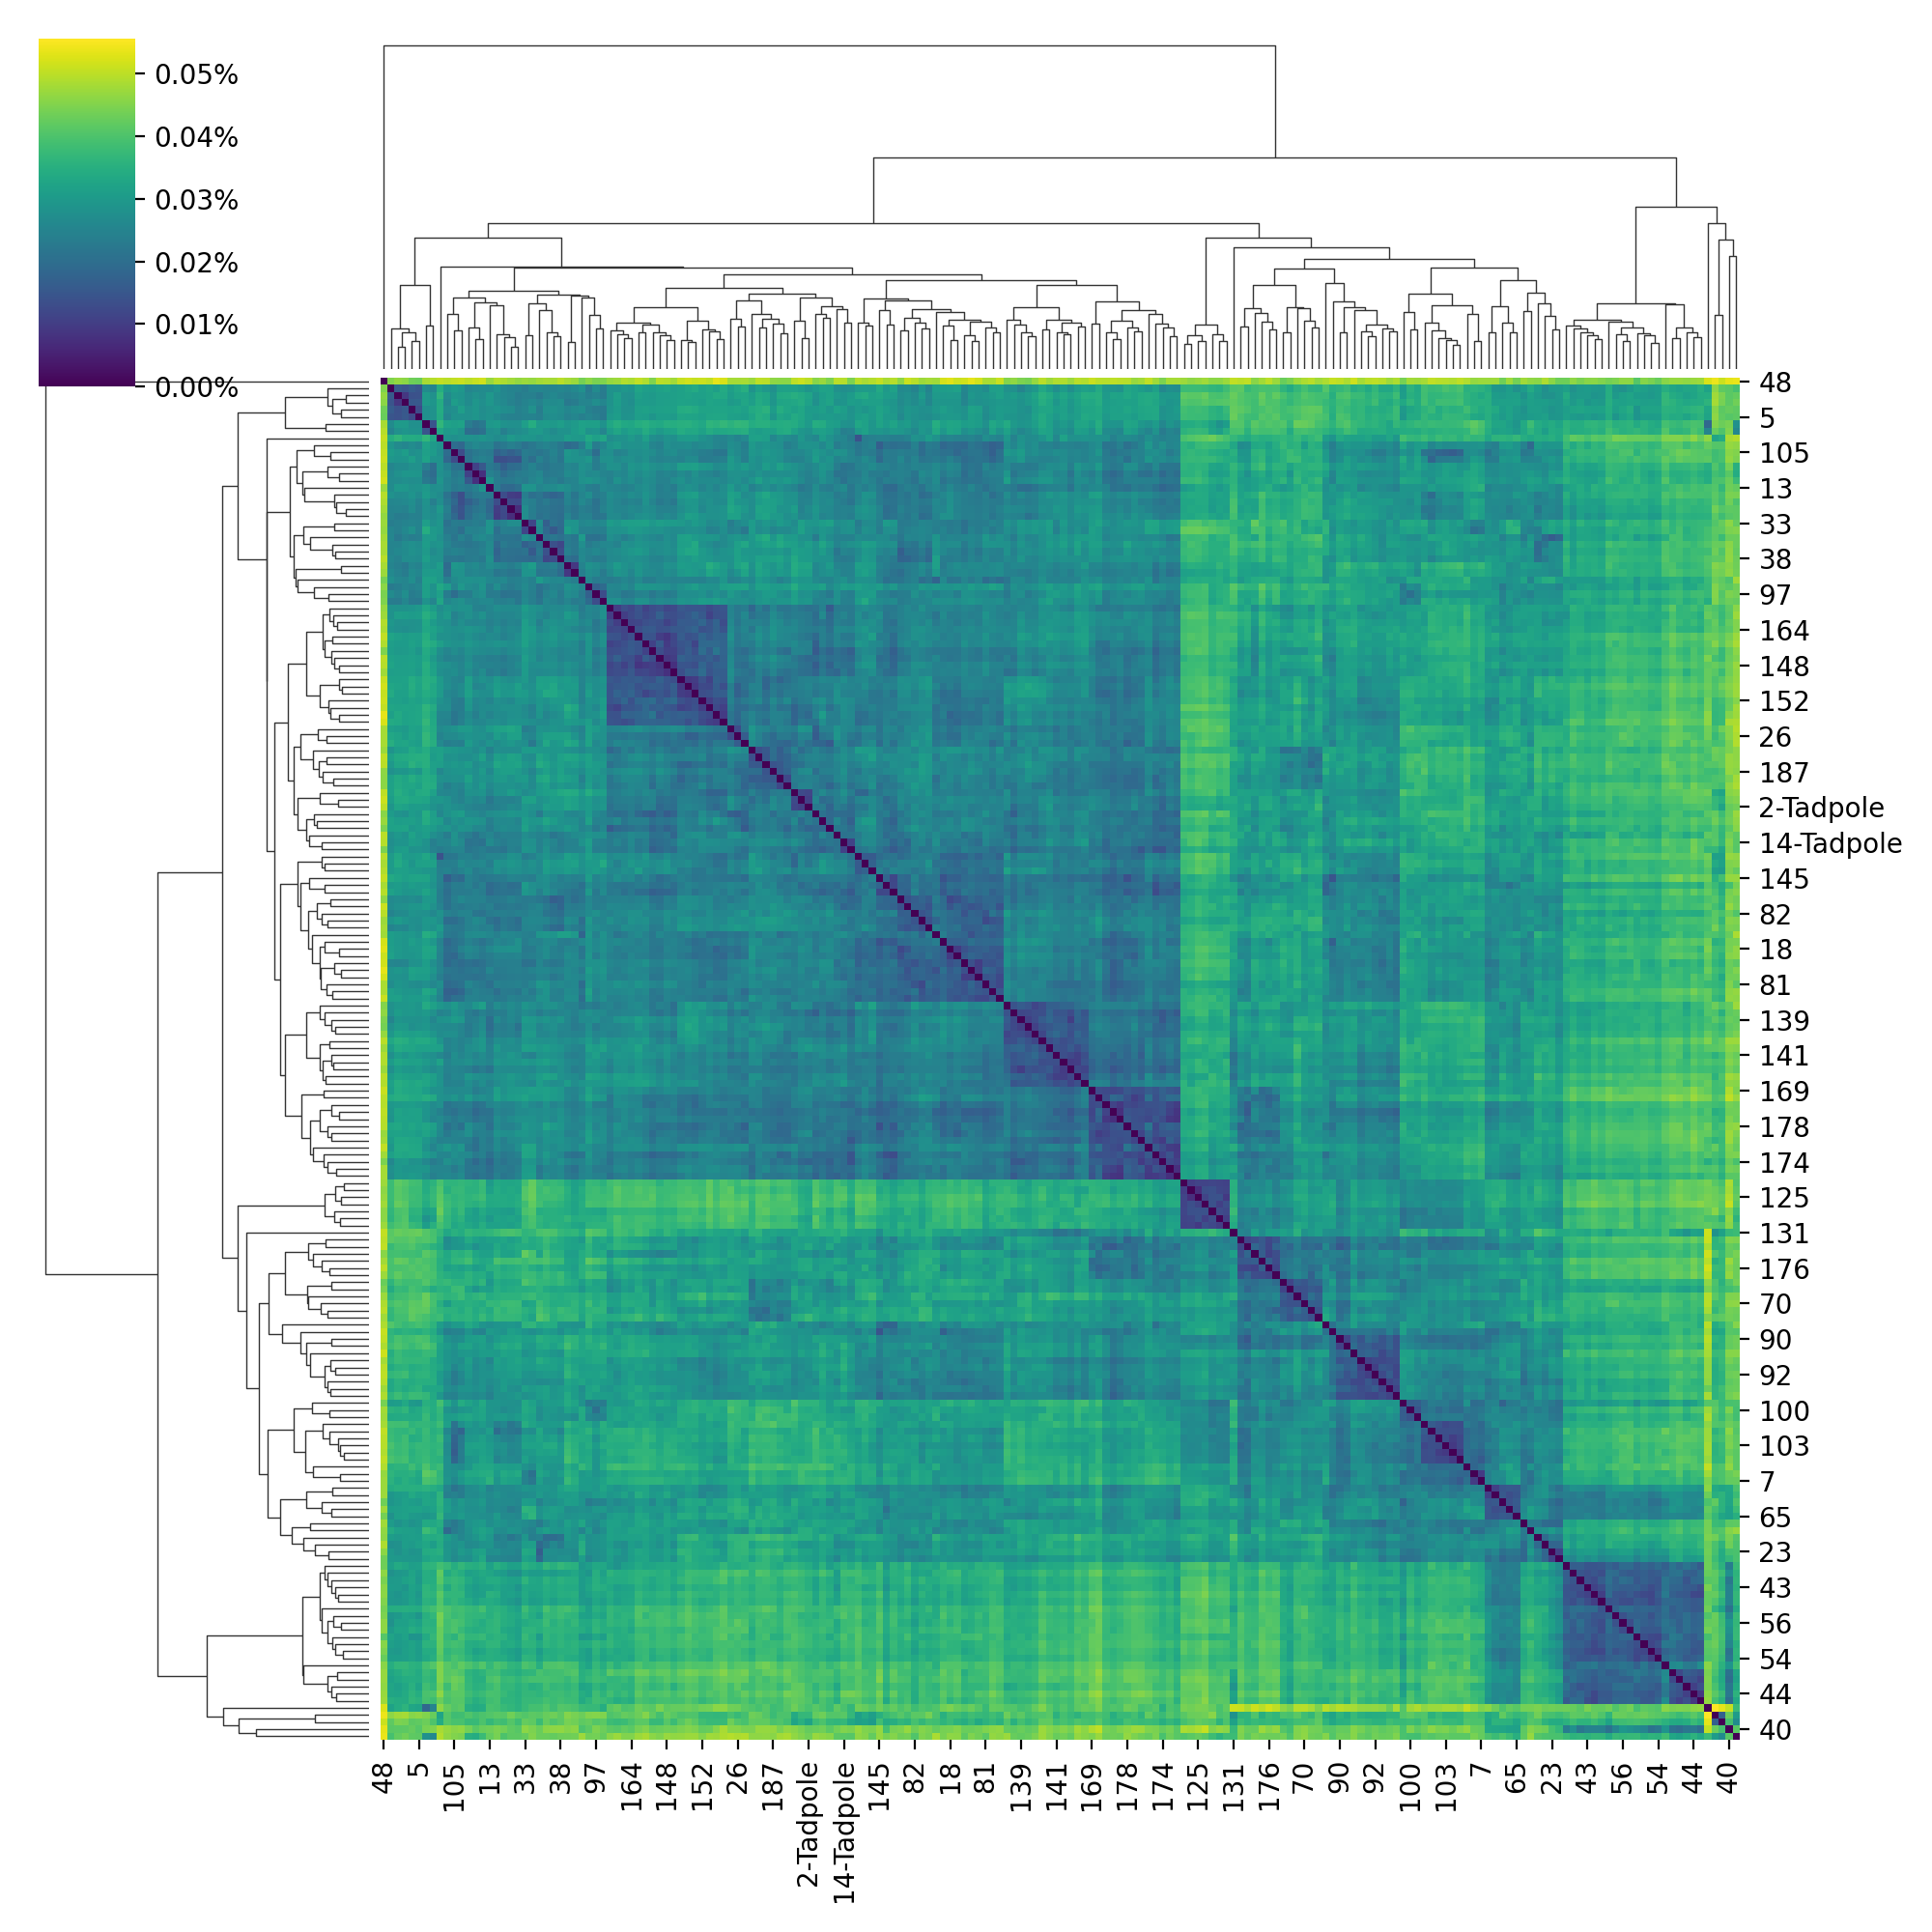

In [6]:
# Supplementary figure 4
# Impute missing values from genotype matrix
from sklearn.impute import KNNImputer

df_geno_num = pd.read_csv("~/xentro/data/genotype/genotype_matrix_numerical.txt", sep='\t') # output from bsbolt GenotypeMatrix 0,1,2 encoding
sites = df_geno_num['Site']
df_numeric = df_geno_num.drop(columns=['Site'])
imputer = KNNImputer(n_neighbors=5)  # You can change n_neighbors as needed
df_imputed = imputer.fit_transform(df_numeric)
df_imputed = pd.DataFrame(df_imputed, columns=df_numeric.columns)
df_imputed.insert(0, 'Site', sites)
df_imputed.set_index('Site', inplace=True)
newcolnames = []
for col in df_imputed.columns:
    newcolnames.append(col.split('.')[0])
df_imputed.columns = newcolnames

# Supplementary figure 4A
# Count SNP differences from imputed matrix
column_tank_map = {col: ad100.var['Tank'][col] for col in df_imputed.columns}
unique_tanks = list(set(column_tank_map.values()))
tank_to_columns = {tank: [col for col, t in column_tank_map.items() if t == tank] for tank in unique_tanks}
tank_differences = np.zeros((len(unique_tanks), len(unique_tanks)))
for i, tank1 in enumerate(unique_tanks):
    for j, tank2 in enumerate(unique_tanks):
        cols_tank1, cols_tank2 = tank_to_columns[tank1], tank_to_columns[tank2]
        differences = [] # Pairwise differences between columns from the two tanks
        for col1 in cols_tank1:
            for col2 in cols_tank2:
                # Count number of SNP differences.
                # Divide by number of callable bases (1003455) to get fraction of genetic variation.
                # Multiply by 100 to get percent.
                diff = sum(df_imputed[col1] != df_imputed[col2]) / 1003455 * 100
                differences.append(diff)
        
        tank_differences[i, j] = np.mean(differences)

from matplotlib.ticker import FormatStrFormatter
tank_differences_df = pd.DataFrame(tank_differences, index=unique_tanks, columns=unique_tanks)
import seaborn as sns
g = sns.clustermap(tank_differences_df, method='average', metric='euclidean', cmap='viridis')
cbar = g.ax_heatmap.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f%%'))
plt.show() # Supplementary figure 4A

# Supplementary figure 4B
differences = np.zeros((192,192))
for i in range(192):
    for j in range(192):
        # Count number of SNP differences.
        # Divide by number of callable bases (1003455) to get fraction of genetic variation.
        # Multiply by 100 to get percent.
        differences[i][j] = sum(df_imputed.iloc[:,i] != df_imputed.iloc[:,j]) / 1003455 * 100
differences_df = pd.DataFrame(differences, index=df_imputed.columns, columns=df_imputed.columns)
g = sns.clustermap(differences_df, method='average', metric='euclidean', cmap='viridis')
cbar = g.ax_heatmap.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f%%'))
plt.show()  # Supplementary figure 4B

/var/folders/mc/f43s8tn57gz077ygd0kl23dc0000gn/T/ipykernel_65094/2887366295.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/mc/f43s8tn57gz077ygd0kl23dc0000gn/T/ipykernel_65094/2887366295.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/mc/f43s8tn57gz077ygd0kl23dc0000gn/T/ipykernel_65094/2887366295.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/mc/f43s8tn57gz077ygd0kl23dc0000gn/T/ipyker

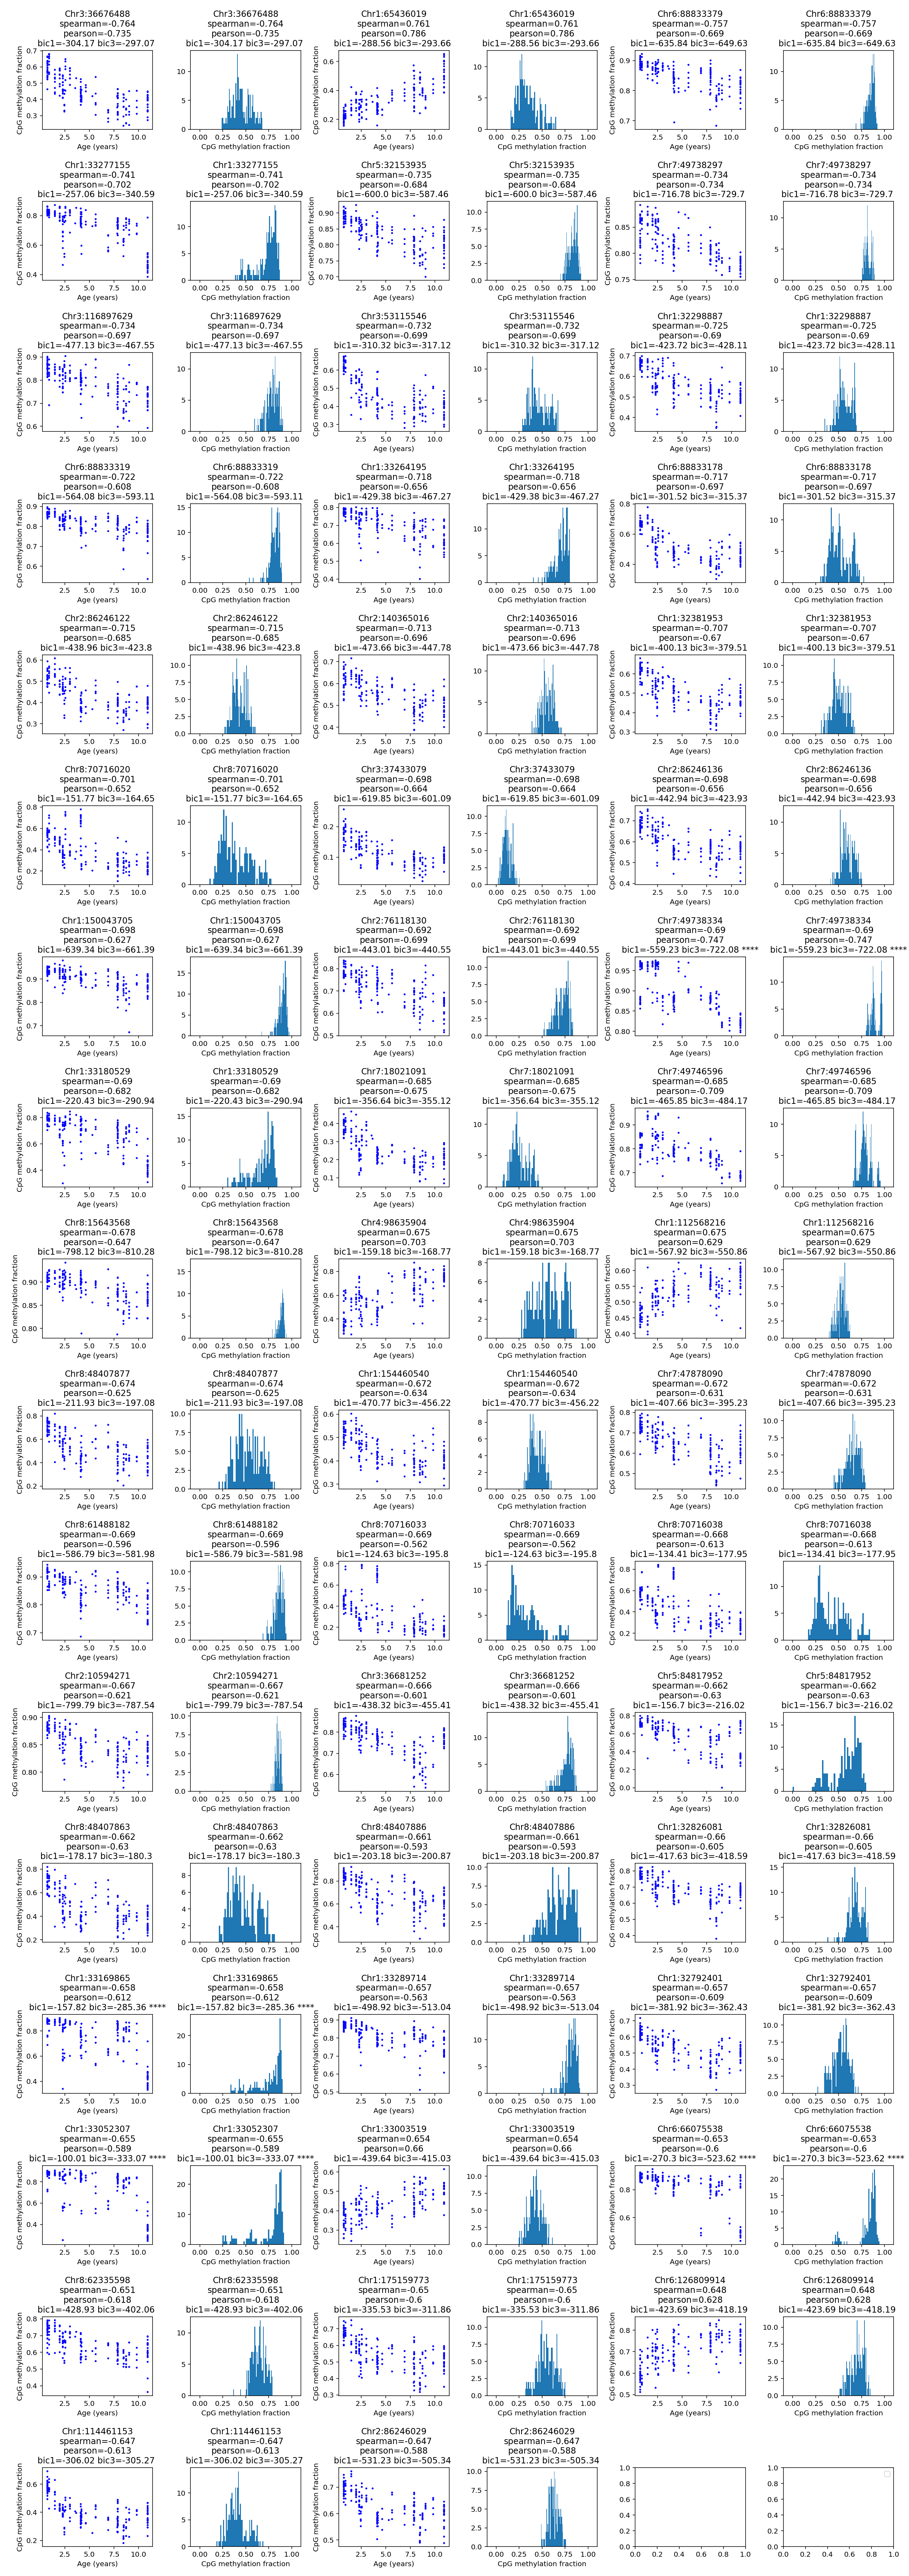

In [12]:
# Supplementary figure 2
# Inspect individual CpGs over age

def fit_gmm(series, n_components):  # this version of the function has .values for the df series
    gmm = sklearn.mixture.GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(series.reshape(-1, 1))
    bic = gmm.bic(series.reshape(-1, 1))
    return bic

def scatter_cpgs(ad_in, AGES_SORTED, num_to_plot, scatter_or_hist=True, colors="blue"):
    # Some of the structure for this code was generated by GPT-4, the rest filled in manually.
    ad_copy = ad_in.copy()
    sorted_idxs = np.abs(ad_copy.obs['spearman']).sort_values(ascending=False).index
    ad_copy = ad_copy[sorted_idxs, :]
    ad_copy = ad_copy[:num_to_plot,:]  # only consider the top
    nc = 6
    assert(nc % 2 == 0)
    nr = len(ad_copy)*2 // nc + 1
    _, axes = plt.subplots(nrows=nr, ncols=nc, figsize=(3*nc, 3*nr))
    axes = axes.flatten()
    for i, (site, row) in enumerate(zip(ad_copy.obs.index, ad_copy.X)):
        x = AGES_SORTED
        y = row

        titles = []
        titles.append(f"{site}")
        titles.append(f"spearman={round(ad_copy.obs.spearman[site],3)}")
        titles.append(f"pearson={round(ad_copy.obs.pearson[site],3)}")
        b1, b2, b3 = fit_gmm(y, 1), fit_gmm(y, 2), fit_gmm(y, 3)
        is_clustered = abs(b3 - b1) > 90
        titles.append(f"bic1={round(fit_gmm(y, 1), 2)} bic3={round(fit_gmm(y, 3), 2)} {'****' if is_clustered else ''}")

        local_colors = colors
        if ad_copy.obs['is_genetic'][i]:
            local_colors = "red"

        axes[2*i].set_title('\n'.join(titles))
        axes[2*i].scatter(x, y, s=3, c=local_colors)
        axes[2*i].set_xlabel("Age (years)")
        axes[2*i].set_ylabel("CpG methylation fraction")
        # axes[2*i].set_ylim(-0.1, 1.1)  # Maybe comment out

        axes[2*i+1].set_title('\n'.join(titles))
        axes[2*i+1].hist(y.copy(), bins=50)  # copy because hist() doesn't like its input being a view
        axes[2*i+1].set_xlabel("CpG methylation fraction")
        axes[2*i+1].set_xlim(-0.1, 1.1)
        
    plt.tight_layout()
    # for strain, color in strain_to_color.items():
    #     plt.scatter([], [], c=color, label=strain)
    plt.legend()
    plt.show()

d = ad100_notadpoles
# d = ad100_all  # includes sites with artifacts suspected to be caused by genetic variation
# d = ad100 

scatter_cpgs(d, np.array(get_ages(d)), 50, scatter_or_hist=False, \
    # colors='blue'
    colors=['red' if is_special else 'blue' for is_special in d.var["Is tadpole?"]]
    # colors=['red' if name == '121' else 'blue' for name in d.var_names]
    )